In [4]:
import pickle
from tqdm import tqdm
from scipy import stats

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    use_columns = list(range(9)) 
    df = pd.read_csv(file,delimiter=',', usecols=use_columns)
    return df

def extract_traceid_rows(df, tid):
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls


def df_to_tracesdict(df):
    '''
    Args: Alibaba traces dataframe
    Return: Dict, Key:tid, Val:list of edges
    '''
    tids_list = df['traceid'].unique().tolist()
    traces_edges = {}
    for i in tqdm(range(len(tids_list))):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        t_edges = [] # list of edges of trace
        for call in tid_calls:
            if call.rpcid != "0":
                t_edges.append([call.um, call.dm])
        traces_edges[tids_list[i]] = t_edges
    return traces_edges

def df_rpcid_analysis(df):
    tids_list = df['traceid'].unique().tolist()
    no_inode_tids = []
    no_inode_tid_rpcid = {}
    for i in tqdm(range(len(tids_list))):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        initial_node = ''
        for call in tid_calls:
            if call.rpcid == "0":
                initial_node = call.dm
        if initial_node == '':
            no_inode_tids.append(tids_list[i])
    for i in tqdm(range(len(no_inode_tids))):
        tid_calls = extract_traceid_rows(df, no_inode_tids[i])
        for call in tid_calls:
            if no_inode_tids[i] not in no_inode_tid_rpcid:
                no_inode_tid_rpcid[no_inode_tids[i]] = []
            no_inode_tid_rpcid[no_inode_tids[i]].append(call.rpcid)

    return no_inode_tid_rpcid

def build_digraph_from_tracesdict(traces_dict):

    full_graph_edge_list = []
    for edge_list in traces_dict.values():
        full_graph_edge_list.extend(edge_list)
    G = nx.DiGraph()
    G.add_edges_from(full_graph_edge_list)

    return G

def pkl_to_dict(file_path):
    with open(file_path, 'rb') as pkl_file:
        T_prime = pickle.load(pkl_file)
    return T_prime

def pkl_to_graph(exp_name):
    file_path = 'downsampled_graphs/' + exp_name + '.pkl'
    T_prime = pkl_to_dict(file_path)
    sampled_G = build_digraph_from_tracesdict(T_prime)

    return sampled_G

def find_inode_and_graph_depth(G):
    max_depth = -1
    node_with_max_depth = ''

    for node in G.nodes():
        depth = calc_graph_depth(G, node)
        if depth > max_depth:
            max_depth = depth
            node_with_max_depth = node
    return node_with_max_depth, max_depth

def calc_graph_depth(G, initial_node):
    def dfs(node, visited, stack):
        # Using stack to avoid cycles
        if node in stack:
            return 0
        if node in visited:
            return visited[node]
        stack.add(node)
        max_depth = 0
        for neighbour in G.successors(node):
            depth = dfs(neighbour, visited, stack)
            max_depth = max(max_depth, depth)
        stack.remove(node)
        visited[node] = max_depth + 1
        
        return visited[node]
    
    visited = {}
    stack = set()
    return dfs(initial_node, visited, stack)

def get_cd_dist(traces_dict):
    '''
    Return: Arr of calldepths of traces
    '''
    T_details = pkl_to_dict('node_and_trace_details/trace_details_data.pkl')
    cd_dist = []
    for tid, t_edges in traces_dict.items():
        G = nx.DiGraph()
        G.add_edges_from(t_edges)
        t_ini_node = T_details[tid][2]
        if t_ini_node not in G.nodes():# ns sample issue: remapped nodes need new inode
            t_ini_node, _ = find_inode_and_graph_depth(G)
            if t_ini_node not in G.nodes():
                continue
        trace_depth = calc_graph_depth(G, t_ini_node)
        cd_dist.append(trace_depth)
    return cd_dist

def get_clust_coeff_dist(G):
    '''
    Clustering Coefficient distribution
    '''
    return list(nx.clustering(G).values())

In [5]:
# '''
# Read & Build Original Graph
# '''
# df = csv_to_df("./casper_rebuild_cleaned.csv")

# # Extract all tids
# tids_list = df['traceid'].unique()
# num_traces = len(tids_list)
# print("Num of tids: ", num_traces)

# # Building the full original digraph
# T_original = df_to_tracesdict(df)
# G_original = build_digraph_from_tracesdict(T_original)

# print("Number of nodes:", G_original.number_of_nodes())

Num of tids:  8937


100%|██████████| 8937/8937 [02:56<00:00, 50.56it/s]


Number of nodes: 3987


In [8]:
'''
Read & Build Sampled graphs
Node Reduction Evaluation Experiments
'''

T_original = pkl_to_dict('node_and_trace_details/original_traces_edges_dict.pkl')

T_ps_4x = pkl_to_dict('downsampled_graphs/prime/node_reduction/ps_2000nodes_70ktraces(4x).pkl')
T_ps_8x = pkl_to_dict('downsampled_graphs/prime/node_reduction/ps_1000nodes_50ktraces(8x).pkl')
T_ps_12x = pkl_to_dict('downsampled_graphs/prime/node_reduction/ps_700nodes_50ktraces(12x).pkl')
T_ps_16x = pkl_to_dict('downsampled_graphs/prime/node_reduction/ps_500nodes_50ktraces(16x).pkl')

T_ns_4x = pkl_to_dict('downsampled_graphs/naive/node_reduction/ns_2000nodes_50ktraces(4x).pkl')
T_ns_8x = pkl_to_dict('downsampled_graphs/naive/node_reduction/ns_1000nodes_50ktraces(8x).pkl')
T_ns_12x = pkl_to_dict('downsampled_graphs/naive/node_reduction/ns_700nodes_50ktraces(12x).pkl')
T_ns_16x = pkl_to_dict('downsampled_graphs/naive/node_reduction/ns_500nodes_50ktraces(16x).pkl')

# Building the sampled original digraph
G_original = build_digraph_from_tracesdict(T_original)

G_ps_4x = build_digraph_from_tracesdict(T_ps_4x)
G_ps_8x = build_digraph_from_tracesdict(T_ps_8x)
G_ps_12x = build_digraph_from_tracesdict(T_ps_12x)
G_ps_16x = build_digraph_from_tracesdict(T_ps_16x)

G_ns_4x = build_digraph_from_tracesdict(T_ns_4x)
G_ns_8x = build_digraph_from_tracesdict(T_ns_8x)
G_ns_12x = build_digraph_from_tracesdict(T_ns_12x)
G_ns_16x = build_digraph_from_tracesdict(T_ns_16x)


In [9]:
'''
In & Out degree distribution
'''
def in_out_deg_dist_viz_cdf(Gs_and_labels, fig_name, plot_title):
    '''
    Generates a CDF graph for in and out deg dist of graphs
    Args: Gs_and_label= [[G, label], [], ...],
          in_or_out= 'in' or 'out'
    '''
    for G, label in Gs_and_labels:
        # get deg dist
        in_degrees = G.in_degree(G.nodes())
        out_degrees = G.out_degree(G.nodes())
        indeg_dist = np.sort([tup[1] for tup in list(in_degrees)])
        outdeg_dist = np.sort([tup[1] for tup in list(out_degrees)])
        
        in_y_vals = np.arange(len(indeg_dist))/float(len(indeg_dist))
        out_y_vals = np.arange(len(outdeg_dist))/float(len(outdeg_dist))
        plt.plot(indeg_dist, in_y_vals, label=f"{label} (In-degree)")
        plt.plot(outdeg_dist, out_y_vals, label=f"{label} (Out-degree)", linestyle='--')

    plt.xlabel('Degree')
    plt.xscale('log')
    plt.ylabel('CDF')
    plt.title(plot_title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plt.savefig(f"figs/{fig_name}.png")
    plt.close()

def deg_dist_viz_cdf(Gs_and_labels, in_or_out, fig_name):
    '''
    Generates a CDF graph for in/out deg dist of graphs
    Args: Gs_and_label= [[G, label], [], ...],
          in_or_out= 'in' or 'out'
    '''
    for G, label in Gs_and_labels:
        if in_or_out == 'in':
            degrees = G.in_degree(G.nodes())
        elif in_or_out == 'out':
            degrees = G.out_degree(G.nodes())
        deg_dist = [tup[1] for tup in list(degrees)]
        x_vals = np.sort(deg_dist)
        y_vals = np.arange(len(deg_dist))/float(len(deg_dist))
        plt.plot(x_vals, y_vals, label=label)
    if in_or_out == "in":
        plt.xlabel('In-degree')
    if in_or_out == "out":
        plt.xlabel('Out-degree')
    plt.xscale('log')
    plt.ylabel('CDF')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plt.savefig(f"figs/{fig_name}.png")
    plt.close()


def deg_dist_viz_hist(Gs_and_labels, in_or_out):
    '''
    Generates a histogram for in/out deg dist of graphs
    Args: Gs_and_label= [[G, label], [], ...],
          in_or_out= 'in' or 'out'
    '''
    for G, label in Gs_and_labels:
        if in_or_out == 'in':
            degrees = G.in_degree(G.nodes())
        elif in_or_out == 'out':
            degrees = G.out_degree(G.nodes())
        deg_dist = [tup[1] for tup in list(degrees)]
        plt.hist(deg_dist,alpha=0.4, label=label)#bins=range(min(deg_dist), max(deg_dist) + 1)
    if in_or_out == "in":
        plt.xlabel('In-degree')
    elif in_or_out == "out":
        plt.xlabel('Out-degree')
        
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

def get_deg_dist(G, in_or_out):
    if in_or_out == "in":
        deg_dist = [tup[1] for tup in list(G.in_degree(G.nodes()))]
    elif in_or_out == "out":
        deg_dist = [tup[1] for tup in list(G.out_degree(G.nodes()))]
    return deg_dist


In [5]:
# Original_indeg_dist = [tup[1] for tup in list(G_original.in_degree(G_original.nodes()))]
# Original_outdeg_dist = [tup[1] for tup in list(G_original.out_degree(G_original.nodes()))]

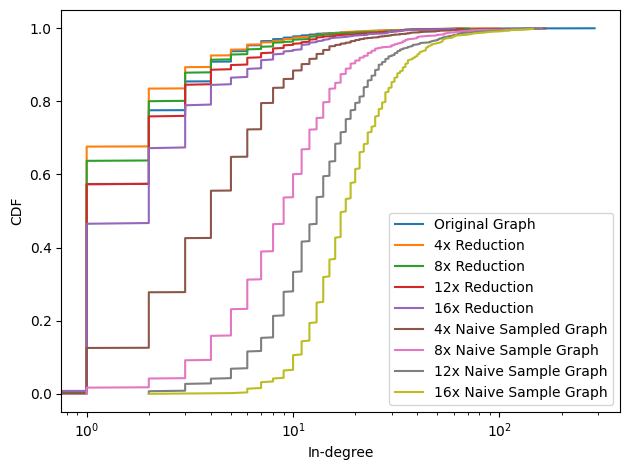

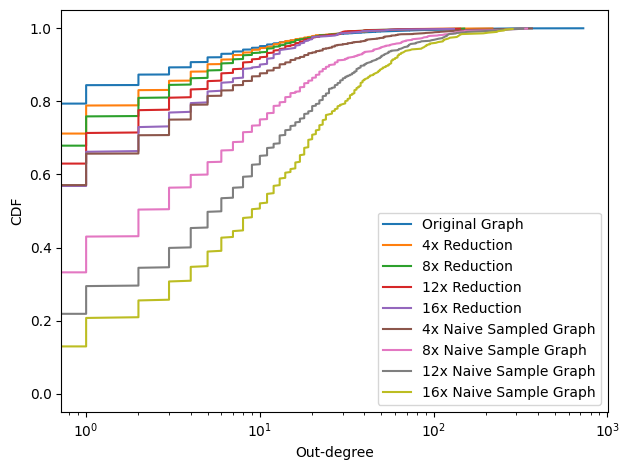

In [10]:
'''
Experiment for Node Downscaling Impact
'''

Gs_and_labels = [[G_original, 'Original Graph'],\
                 [G_ps_4x, '4x Reduction'],\
                 [G_ps_8x, '8x Reduction'],\
                 [G_ps_12x, '12x Reduction'],\
                 [G_ps_16x, '16x Reduction'],\
                 [G_ns_4x, '4x Naive Sampled Graph'],\
                 [G_ns_8x, '8x Naive Sample Graph'],\
                 [G_ns_12x, '12x Naive Sample Graph'],\
                 [G_ns_16x, '16x Naive Sample Graph']
                 ]
deg_dist_viz_cdf(Gs_and_labels, 'in',\
                  'node_dscaling_impact/indeg_dist_dscale_4.5kt')
deg_dist_viz_cdf(Gs_and_labels, 'out',\
                  'node_dscaling_impact/outdeg_dist_dscale_4.5kt')
# in_out_deg_dist_viz_cdf(Gs_and_labels, \
#                 'node_dscaling_impact/inoutdeg_dist_dscale_4.5kt',\
#                 'Node Downscaling Impact')

In [30]:
'''
Experiment for Comparing impact of t' on in/out deg distributions
'''

G_300n_4500t = pkl_to_graph('300nodes_4500traces')
G_300n_2250t = pkl_to_graph('300nodes_2250traces')


Gs_and_labels = [[G_original, 'Original Graph(3655n:10421t)'],[G_300n_4500t, '(13x)Sampled Graph(300n:4500t)'], \
                 [G_300n_2250t, '(13x)Sampled Graph(300n:2250t)']]

in_out_deg_dist_viz_cdf(Gs_and_labels, \
                'num_traces_impact/inoutdeg_dist_timpact_4.5kt',\
                'Num traces Impact')

In [ ]:
'''
Sfsl ratio
'''
node_details_dict = pkl_to_dict('downsampled_graphs/node_details_data.pkl')

def calc_sfsl_ratio(G, node_details_dict):
    '''
    Args: node_details_dict= Key: Nodeid, Val: type
    Returns: sfsl ratio
    '''
    sf_ctr = 0
    sl_ctr = 0
    num_nodes = len(G.nodes())
    for node in G.nodes():
        if node in node_details_dict and node_details_dict[node][1] == 'db':
            sf_ctr += 1
        else:
            sl_ctr += 1
    sfsl_ratio = sf_ctr/sl_ctr
    print("Total nodes: ", num_nodes)
    print("sfsl ratio: ", sfsl_ratio)
    print("Sf percent: ", (sf_ctr/num_nodes)*100)
    print("Sl percent: ", (sl_ctr/num_nodes)*100)
    
G_300n_2250t = pkl_to_graph('300nodes_2250traces')
G_500n_2250t = pkl_to_graph('500nodes_2250traces')
calc_sfsl_ratio(G_original, node_details_dict)
calc_sfsl_ratio(G_prime_300, node_details_dict)
calc_sfsl_ratio(G_prime_500, node_details_dict)
calc_sfsl_ratio(G_300n_2250t, node_details_dict)
calc_sfsl_ratio(G_500n_2250t, node_details_dict)

['(4x)', '(8x)', '(12x)', '(16x)']
[np.float64(0.06236823226127258), np.float64(0.06244643142846823), np.float64(0.062486438629764496), np.float64(0.06366665106800334)]
[np.float64(0.07019056057171397), np.float64(0.06977812118184962), np.float64(0.06941812118184962), np.float64(0.06897812118184961)]


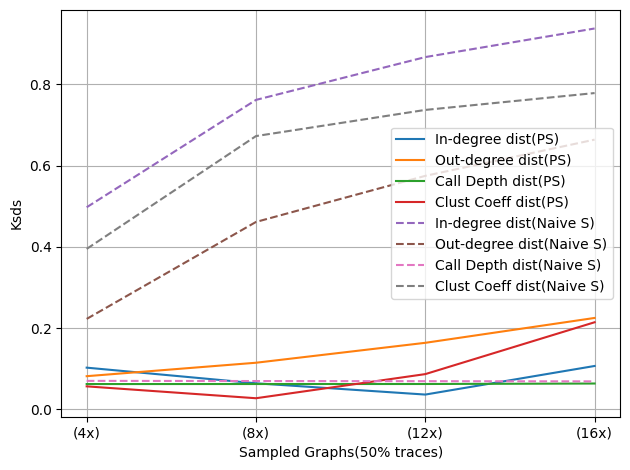

In [21]:
'''
KSDS experiment
'''
class G_ksds_eval_info:
    def __init__(self,G,traces_dict, label, samp_method, plt_format='Samp') -> None:
        self.indeg_dist = get_deg_dist(G, 'in')
        self.outdeg_dist = get_deg_dist(G, 'out')
        self.cd_dist = get_cd_dist(traces_dict)
        self.clust_coeff_dist = get_clust_coeff_dist(G)
        self.label = label
        self.samp_method = samp_method
        self.plt_format = plt_format

G_original_eval = G_ksds_eval_info(G_original, T_original,'Original Graph', 'ps')

G_ps_4x_ksds_eval = G_ksds_eval_info(G_ps_4x, T_ps_4x, '(4x)', 'ps')
G_ps_8x_ksds_eval = G_ksds_eval_info(G_ps_8x, T_ps_8x, '(8x)', 'ps')
G_ps_12x_ksds_eval = G_ksds_eval_info(G_ps_12x, T_ps_12x, '(12x)', 'ps')
G_ps_16x_ksds_eval = G_ksds_eval_info(G_ps_16x, T_ps_16x, '(16x)', 'ps')

G_ns_4x_ksds_eval = G_ksds_eval_info(G_ns_4x, T_ns_4x, '(4x)', 'ns', '--')
G_ns_8x_ksds_eval = G_ksds_eval_info(G_ns_8x, T_ns_8x, '(8x)', 'ns', '--')
G_ns_12x_ksds_eval = G_ksds_eval_info(G_ns_12x, T_ns_12x, '(12x)', 'ns', '--')
G_ns_16x_ksds_eval = G_ksds_eval_info(G_ns_16x, T_ns_16x, '(16x)', 'ns', '--')

ksds_exp_input = [G_ps_4x_ksds_eval, G_ps_8x_ksds_eval, G_ps_12x_ksds_eval, G_ps_16x_ksds_eval,\
                  G_ns_4x_ksds_eval, G_ns_8x_ksds_eval, G_ns_12x_ksds_eval, G_ns_16x_ksds_eval]

# ksds_exp_input_ns = [ G_ns_500n_ksds_eval, G_ns_300n_ksds_eval]
def ksds_experiment(ksds_exp_input, g_org_eval):
    '''
    Args: ksds_exp_input= [List of graphs in G_eval_info() object format],
          g_org_eval= G_eval_info() object of orignal graph.
    '''
    indeg_ksds_ps_arr = []
    outdeg_ksds_ps_arr = []
    cd_ksds_ps_arr = []
    clust_ksds_ps_arr = []
    indeg_ksds_ns_arr = []
    outdeg_ksds_ns_arr = []
    cd_ksds_ns_arr = []
    clust_ksds_ns_arr = []
    glabel_arr = []
    for g_eval in ksds_exp_input:
        indeg_ksds, indeg_p_val = stats.ks_2samp(g_org_eval.indeg_dist, g_eval.indeg_dist)
        outdeg_ksds, outdeg_p_val = stats.ks_2samp(g_org_eval.outdeg_dist, g_eval.outdeg_dist)
        cd_ksds, cd_p_val = stats.ks_2samp(g_org_eval.cd_dist, g_eval.cd_dist)
        clust_ksds, clust_p_val = stats.ks_2samp(g_org_eval.clust_coeff_dist, g_eval.clust_coeff_dist)
        if g_eval.samp_method == "ps":
            indeg_ksds_ps_arr.append(indeg_ksds)
            outdeg_ksds_ps_arr.append(outdeg_ksds)
            cd_ksds_ps_arr.append(cd_ksds)
            clust_ksds_ps_arr.append(clust_ksds)
        elif g_eval.samp_method == "ns":
            indeg_ksds_ns_arr.append(indeg_ksds)
            outdeg_ksds_ns_arr.append(outdeg_ksds)
            cd_ksds_ns_arr.append(cd_ksds)
            clust_ksds_ns_arr.append(clust_ksds)
        if g_eval.label not in glabel_arr:
            glabel_arr.append(g_eval.label)
        # cd_ksds, cd_p_val = stats.ks_2samp(g_org_eval.cd_dist, g_eval.cd_dist)
    print(glabel_arr)
    print(cd_ksds_ps_arr)
    print(cd_ksds_ns_arr)
    plt.plot(glabel_arr, indeg_ksds_ps_arr, label=f"In-degree dist(PS)")
    plt.plot(glabel_arr, outdeg_ksds_ps_arr, label=f"Out-degree dist(PS)")
    plt.plot(glabel_arr, cd_ksds_ps_arr, label=f"Call Depth dist(PS)")
    plt.plot(glabel_arr, clust_ksds_ps_arr, label=f"Clust Coeff dist(PS)")
    plt.plot(glabel_arr, indeg_ksds_ns_arr, label=f"In-degree dist(Naive S)", linestyle="--")
    plt.plot(glabel_arr, outdeg_ksds_ns_arr, label=f"Out-degree dist(Naive S)", linestyle="--")
    plt.plot(glabel_arr, cd_ksds_ns_arr, label=f"Call Depth dist(Naive S)", linestyle="--")
    plt.plot(glabel_arr, clust_ksds_ns_arr, label=f"Clust Coeff dist(Naive S)", linestyle="--")
    plt.grid(True)
    plt.xlabel('Sampled Graphs(50% traces)')
    plt.yscale('linear')
    plt.ylabel('Ksds')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"figs/ksds_50per_with_ns.png")


ksds_experiment(ksds_exp_input, G_original_eval)

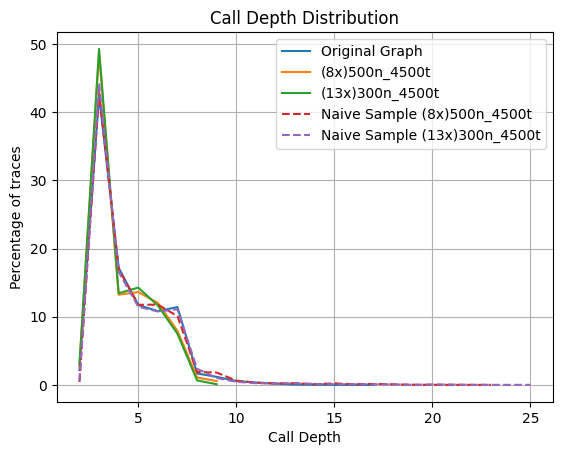

In [18]:
'''
Call depth percentage distribution
'''

T_details = pkl_to_dict('downsampled_graphs/trace_details_data.pkl')

def call_depth_percentages(traces_dict, T_details):
    '''
    Returns: cd_percent_arr=[[cd, percent], [cd, percent], ....]
    '''
    cd_count_dict = {}
    traces_count = 0
    check_inode_not_in_g = []
    for tid, t_edges in traces_dict.items():
        traces_count += 1
        G = nx.DiGraph()
        G.add_edges_from(t_edges)
        t_ini_node = T_details[tid][2]
        if t_ini_node not in G.nodes():# ns sample issue: remapped nodes need new inode
            check_inode_not_in_g.append(tid)
            t_ini_node, _ = find_inode_and_graph_depth(G)
            if t_ini_node not in G.nodes():
                continue
        trace_depth = calc_graph_depth(G, t_ini_node)
        if trace_depth not in cd_count_dict:
            cd_count_dict[trace_depth] = 1
        else:
            cd_count_dict[trace_depth] += 1

    cd_percent_arr = []
    for cd in cd_count_dict:
        percent_t_cd = 100 * cd_count_dict[cd]/traces_count
        cd_percent_arr.append([cd, percent_t_cd])
    cd_percent_arr.sort(key=lambda x: x[0])

    # print(cd_percent_arr)
    # print(len(check_inode_not_in_g))
    return cd_percent_arr

class G_cd_eval_info:
    def __init__(self, traces_dict, T_details, label, plt_format='line') -> None:
        self.percent_arr = call_depth_percentages(traces_dict, T_details)
        self.label = label
        self.plt_format = plt_format

T_prime_500n_2250t = pkl_to_dict('downsampled_graphs/500nodes_2250traces.pkl')
T_prime_300n_2250t = pkl_to_dict('downsampled_graphs/300nodes_2250traces.pkl')



G_original = G_cd_eval_info(T_original, T_details, 'Original Graph')
G_prime_500n_4500t = G_cd_eval_info(T_prime_500n_4500t, T_details, '(8x)500n_4500t')
# G_prime_500n_2250t = G_cd_eval_info(T_prime_500n_2250t, T_details, '(8x)500n_2250t')
G_prime_300n_4500t = G_cd_eval_info(T_prime_300n_4500t, T_details, '(13x)300n_4500t')
# G_prime_300n_2250t = G_cd_eval_info(T_prime_300n_2250t, T_details, '(13x)300n_2250t')
G_ns_500n_4500t = G_cd_eval_info(T_ns_500n_4500t, T_details, 'Naive Sample (8x)500n_4500t', '--')
G_ns_300n_4500t = G_cd_eval_info(T_ns_300n_4500t, T_details, 'Naive Sample (13x)300n_4500t', '--')


cd_eval_arr = [G_original,G_prime_500n_4500t,G_prime_300n_4500t,\
               G_ns_500n_4500t,G_ns_300n_4500t]

# ,G_prime_500n_4500t,G_prime_300n_4500t

def call_depth_eval_exp(cd_eval_arr):

    for g_cd_eval_info in cd_eval_arr:
        cd_percent_arr = g_cd_eval_info.percent_arr
        label = g_cd_eval_info.label
        # print(label)
        valid_cds = [x[0] for x in cd_percent_arr]
        cd_percentages = [x[1] for x in cd_percent_arr]
        # print(cd_percent_arr)
        if g_cd_eval_info.plt_format == '--':
            plt.plot(valid_cds, cd_percentages, label=f"{label}", linestyle='--')
        else:
            plt.plot(valid_cds, cd_percentages, label=f"{label}")
        
    plt.grid(True)
    plt.xlabel('Call Depth')
    plt.ylabel('Percentage of traces')
    plt.title('Call Depth Distribution')
    plt.legend() 
    plt.savefig('figs/cd_distribution_eval_with_ns.png')
    # plt.show()
    
call_depth_eval_exp(cd_eval_arr)

In [7]:

def plot_graph_simple(graph, filename, special_node=None):
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    
    # Generate positions for nodes
    pos = nx.spring_layout(graph)
    
    # Default node color
    node_colors = ['lightblue' if node != special_node else 'orange' for node in graph.nodes]
    
    # Draw the graph
    nx.draw(graph, pos, with_labels=False, node_color=node_colors, edge_color='black')
    
    # Save the figure with high quality
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
'''
Re-assign initial Nodes
'''
def calc_graph_depth(G, initial_node):
    def dfs(node, visited, stack):
        # Using stack to avoid cycles
        if node in stack:
            return 0
        if node in visited:
            return visited[node]
        stack.add(node)
        max_depth = 0
        for neighbour in G.successors(node):
            depth = dfs(neighbour, visited, stack)
            max_depth = max(max_depth, depth)
        stack.remove(node)
        visited[node] = max_depth + 1
        
        return visited[node]
    
    visited = {}
    stack = set()

    return dfs(initial_node, visited, stack)

def find_inode_and_graph_depth(G):
    max_depth = -1
    node_with_max_depth = ''

    for node in G.nodes():
        depth = calc_graph_depth(G, node)
        if depth > max_depth:
            max_depth = depth
            node_with_max_depth = node
    return node_with_max_depth, max_depth
    
from collections import Counter
T_details = pkl_to_dict('downsampled_graphs/trace_details_data.pkl') 
cd_list = []
for tid, edge_list in T_original.items():
    G = nx.DiGraph()
    G.add_edges_from(edge_list)
    g_inode, call_depth = find_inode_and_graph_depth(G)
    cd_list.append(call_depth)

cds_counter = Counter(cd_list)
cd_percent_arr = []
for cd in cds_counter:
    percent_t_cd = 100 * (cds_counter[cd]/len(cd_list))
    cd_percent_arr.append([cd, percent_t_cd])

cd_percent_arr.sort(key=lambda x: x[0])
valid_cds = [x[0] for x in cd_percent_arr]
cd_percentages = [x[1] for x in cd_percent_arr]
plt.plot(valid_cds, cd_percentages)
plt.grid(True)
plt.xlabel('Call Depth')
plt.ylabel('Percentage of traces')
plt.title('Call Depth Distribution')
# plt.savefig('figs/cd_distribution_from_rpcids.png')
plt.show()

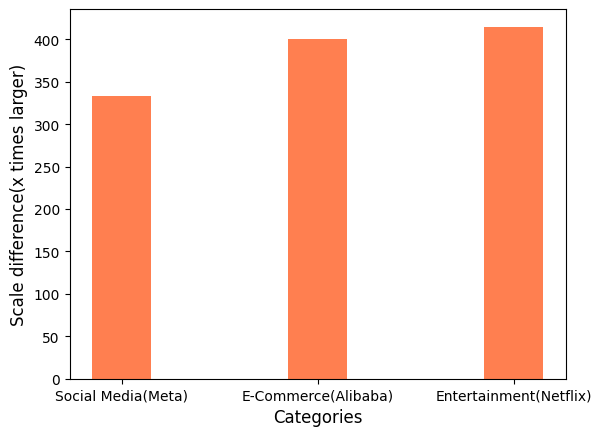

In [11]:
# Intro Figure
import matplotlib.pyplot as plt

# Data
data = {'Social Media(Meta)': 333, 'E-Commerce(Alibaba)': 400, 'Entertainment(Netflix)': 415}

# Create a list of values and labels
values = list(data.values())
labels = list(data.keys())

# Create the bar chart
plt.bar(labels, values, color='coral', width=0.3)

# Add labels and title
plt.ylabel('Scale difference(x times larger)', fontsize=12)
plt.xlabel('Categories', fontsize=12)
# plt.title('Horizontal Bar Chart')

# Show the plot
plt.show()